<a href="https://colab.research.google.com/github/owen198/csc_domain_adaptation/blob/main/csc_lstm_ae(W4662FM0507).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

from sklearn import preprocessing
from sklearn import svm
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# lstm autoencoder to recreate a timeseries
import numpy as np

from keras import metrics
from keras import models
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Input, BatchNormalization, Activation
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
tag1 = 'W4662FM0400'
tag2 = 'W4662FM0507'
path = './gdrive/My Drive/data/CSC/W4/'

In [ ]:

tag1_pd = pd.concat([pd.read_csv(path+tag1+'_202004.csv'),
                       pd.read_csv(path+tag1+'_202005.csv'),
                       pd.read_csv(path+tag1+'_202006.csv'),
                       pd.read_csv(path+tag1+'_202007.csv'),
                       pd.read_csv(path+tag1+'_202008.csv'),
                       pd.read_csv(path+tag1+'_202009.csv')])

tag2_pd = pd.concat([pd.read_csv(path+tag2+'_202009.csv'),
                       pd.read_csv(path+tag2+'_202010.csv'),
                       pd.read_csv(path+tag2+'_202011.csv'),
                       pd.read_csv(path+tag2+'_202012.csv'),
                       pd.read_csv(path+tag2+'_202101.csv'),
                       pd.read_csv(path+tag2+'_202102.csv')])

In [ ]:
tag1_pd['datetime'] = tag1_pd['timestamp'].astype('int').astype("datetime64[s]")
tag2_pd['datetime'] = tag2_pd['timestamp'].astype('int').astype("datetime64[s]")

In [ ]:
tag1_normal = tag1_pd[(tag1_pd['datetime'] > datetime.datetime(2020,4,1,0,0)) & (tag1_pd['datetime'] < datetime.datetime(2020,6,14,0,0))]
tag1_abnormal = tag1_pd[(tag1_pd['datetime'] > datetime.datetime(2020,6,15,0,0)) & (tag1_pd['datetime'] < datetime.datetime(2020,6,27,0,0))]

tag2_normal = tag2_pd[(tag2_pd['datetime'] > datetime.datetime(2020,9,1,0,0)) & (tag2_pd['datetime'] < datetime.datetime(2021,1,8,0,0))]
tag2_abnormal = tag2_pd[(tag2_pd['datetime'] > datetime.datetime(2021,1,9,0,0)) & (tag2_pd['datetime'] < datetime.datetime(2021,2,1,0,0))]

In [ ]:
#list(target_repaired)

tag1_normal_dt = tag1_normal['datetime']
tag1_abnormal_dt = tag1_abnormal['datetime']

tag2_normal_dt = tag2_normal['datetime']
tag2_abnormal_dt = tag2_abnormal['datetime']
'''
original_list = [s for s in list(tag1_normal) if (s.startswith('CREST') or 
                                                      s.startswith('KURT_') or 
                                                      s.startswith('SKEW') or 
                                                      s.startswith('RMS_'))]

tag1_normal = tag1_normal[original_list]
tag1_abnormal = tag1_abnormal[original_list]

tag2_normal = tag2_normal[original_list]
tag2_abnormal = tag2_abnormal[original_list]
'''

"\noriginal_list = [s for s in list(tag1_normal) if (s.startswith('CREST') or \n                                                      s.startswith('KURT_') or \n                                                      s.startswith('SKEW') or \n                                                      s.startswith('RMS_'))]\n\ntag1_normal = tag1_normal[original_list]\ntag1_abnormal = tag1_abnormal[original_list]\n\ntag2_normal = tag2_normal[original_list]\ntag2_abnormal = tag2_abnormal[original_list]\n"

In [ ]:
drop_list = ['Unnamed: 0', '_id','type','scada','timestamp','device', 'datetime']

tag1_normal = tag1_normal.drop(columns=drop_list)
tag1_abnormal = tag1_abnormal.drop(columns=drop_list)


tag2_normal = tag2_normal.drop(columns=drop_list)
tag2_abnormal = tag2_abnormal.drop(columns=drop_list)

In [ ]:
import random

shape_min = min (tag1_normal.shape[0], tag2_normal.shape[0])
shape_max = max (tag1_normal.shape[0], tag2_normal.shape[0])

index = sorted(random.sample(range(0, shape_max), shape_min))

In [ ]:

X_source = tag1_normal
X_target = tag2_normal

X_source_ab = tag1_abnormal
X_target_ab = tag2_abnormal

X_source_dt = tag1_normal_dt
X_target_dt = tag2_normal_dt

X_source_ab_dt = tag1_abnormal_dt
X_target_ab_dt = tag2_abnormal_dt

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(X_source)

X_source = pd.DataFrame(min_max_scaler.transform(X_source))
X_target = pd.DataFrame(min_max_scaler.transform(X_target))

X_source_ab = pd.DataFrame(min_max_scaler.transform(X_source_ab))
X_target_ab = pd.DataFrame(min_max_scaler.transform(X_target_ab))

#target_normal = pd.DataFrame(min_max_scaler.transform(target_normal))
#target_abnormal = pd.DataFrame(min_max_scaler.transform(target_abnormal))

In [ ]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [ ]:

# define input timeseries
'''
timeseries = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()

timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]
timeseries
'''

'\ntimeseries = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],\n                       [0.1**3, 0.2**3, 0.3**3, 0.4**3, 0.5**3, 0.6**3, 0.7**3, 0.8**3, 0.9**3]]).transpose()\n\ntimesteps = timeseries.shape[0]\nn_features = timeseries.shape[1]\ntimeseries\n'

In [ ]:
if len(X_target) > len(X_source):
    X = X_target.iloc[index]
    Y = X_source
else:
    X = X_target
    Y = X_source.iloc[index]


timesteps = 4
n_features = 390

#X, y = temporalize(X = timeseries, y = np.zeros(len(timeseries)), lookback = timesteps)
X, _ = temporalize(X = X.values, y = np.zeros(len(X)), lookback = timesteps)
Y, _ = temporalize(X = Y.values, y = np.zeros(len(Y)), lookback = timesteps)

X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

Y = np.array(Y)
Y = Y.reshape(np.array(Y).shape[0], timesteps, n_features)

# LSTM-AE Model

In [ ]:
def lstm_ae():
    # define model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(timesteps,n_features), return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(RepeatVector(timesteps))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    model.compile(optimizer='adam', loss='mse', metrics=[metrics.RootMeanSquaredError()])
    model.summary()

    return model

In [ ]:
model_name = './gdrive/My Drive/data/CSC/W4/' + tag1 + '_encoded'
model_name

'./gdrive/My Drive/data/CSC/W4/W4662FM0400_encoded'

In [ ]:

retrain = True


if retrain:
    early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=2)

    model = lstm_ae ()
    lstm_ae_model = model.fit(Y, X, epochs=150, batch_size=16, verbose=1, validation_split=0.2, callbacks=[early_stopping])
    model.save(model_name)
else:
    model = models.load_model(model_name)  
    

#model = models.load_model(model_name)    
yhat = model.predict(X, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4, 64)             116480    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 64)             20736     
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 390)            25350     
Total params: 169,862
Trainable params: 169,862
Non-trainable params: 0
__________________________________________________

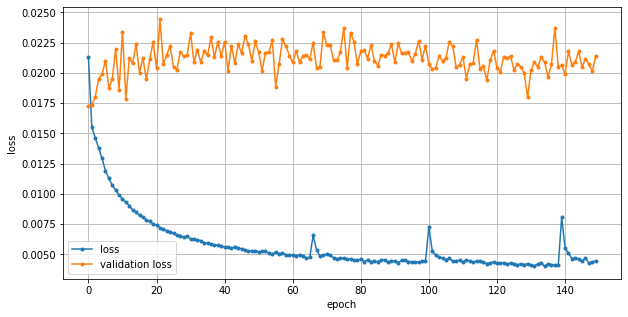

In [ ]:

if retrain:
    fig, ax = plt.subplots(figsize=(10,5))

    ax.plot(lstm_ae_model.history['loss'], marker='.', label='loss')
    ax.plot(lstm_ae_model.history['val_loss'], marker='.', label='validation loss')

    ax.legend()
    ax.grid(True)

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('epoches.png', dpi=300)
    plt.show()

In [ ]:
y_recovered_pd = pd.DataFrame.from_records([i[0] for i in yhat])



# Validation

In [ ]:
from sklearn.decomposition import PCA

pca_scale = PCA(n_components=2)
pca_scale = pca_scale.fit(X_source)

X_source_dr = pca_scale.transform(X_source)
x_min, x_max = X_source_dr.min(0), X_source_dr.max(0)
X_norm = (X_source_dr-x_min) / (x_max-x_min)  #Normalize
X_source_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_target_dr = pca_scale.transform(X_target)
x_min, x_max = X_target_dr.min(0), X_target_dr.max(0)
X_norm = (X_target_dr-x_min) / (x_max-x_min)  #Normalize
X_target_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

X_decoder_dr = pca_scale.transform(y_recovered_pd)
x_min, x_max = X_decoder_dr.min(0), X_decoder_dr.max(0)
X_norm = (X_decoder_dr-x_min) / (x_max-x_min)  #Normalize
X_decode_df = pd.DataFrame(X_norm, columns = ['dim1','dim2'])

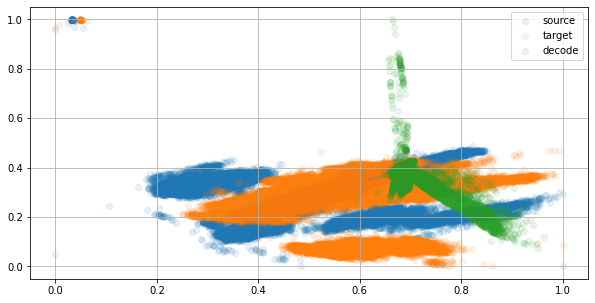

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(X_source_df['dim1'], X_source_df['dim2'], alpha=0.1, label='source')
ax.scatter(X_target_df['dim1'], X_target_df['dim2'], alpha=0.1, label='target')
ax.scatter(X_decode_df['dim1'], X_decode_df['dim2'], alpha=0.1, label='decode')

ax.legend()
ax.grid(True)

#plt.ylim(0, 1)
#plt.xlim(0, 1)
plt.savefig('distribution.png', dpi=300)
plt.show()

In [ ]:
model_source = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(X_source)
model_target = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(X_target)
model_decode = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01).fit(y_recovered_pd)

In [ ]:
def scorer_(Y_pred):
    a = (Y_pred[Y_pred == -1].size)/(Y_pred.size)
    return a*100

In [ ]:
def plot_score (score_list, date_list, tag):

    fig, ax = plt.subplots(figsize=(10, 3))
    plt.xticks(rotation=45)
    ax.plot(date_list, score_list, '.-')
    ax.set(xlabel='date', ylabel='score', title=tag)
    ax.grid()
    plt.ylim(0, 100)
    plt.tight_layout()
    #fig.savefig(path+tag+'-'+training_from.strftime("%Y%m%d")+'-'+training_to.strftime("%Y%m%d")+'.png', dpi=300)
    plt.show()

In [ ]:
def get_score_list(normal_df, abnormal_df, normal_df_dt, abnormal_df_dt, model):

    score_list = []
    date_list = []
    delta = datetime.timedelta(days=1)

    validation_df = normal_df.append(abnormal_df)
    validation_df_dt = normal_df_dt.append(abnormal_df_dt)
    validation_df['datetime'] = validation_df_dt.values

    # calculation duration
    start_date = validation_df.head(1)['datetime'].values[0]
    end_date = validation_df.tail(1)['datetime'].values[0]
    start_date = datetime.datetime.fromtimestamp(start_date.astype('datetime64[s]').astype('int'))
    end_date = datetime.datetime.fromtimestamp(end_date.astype('datetime64[s]').astype('int'))
    
    while start_date <= end_date:
        validation_sub_df = validation_df[(validation_df['datetime'] > start_date) & (validation_df['datetime'] < start_date + delta)]

        if len(validation_sub_df) > 0:

            validation_df_sc = model.predict(validation_sub_df.drop(columns=['datetime']))
            score_list.append(scorer_(validation_df_sc))
            date_list.append(start_date)

        start_date += delta
        
    return score_list, date_list

In [ ]:
target_score_da, target_date_da = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_decode)

target_score_cv, target_date_cv = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_source)

target_score, target_date = get_score_list(X_target, 
                                           X_target_ab, 
                                           X_target_dt, 
                                           X_target_ab_dt, 
                                           model_target)


In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(target_score_cv, target_score, squared=False)

34.86796946568599

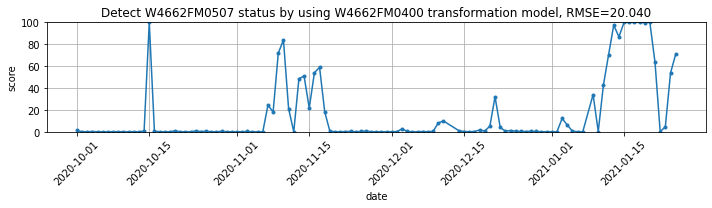

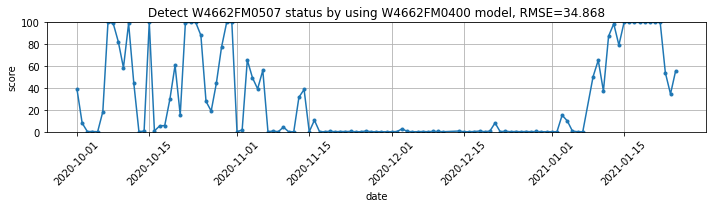

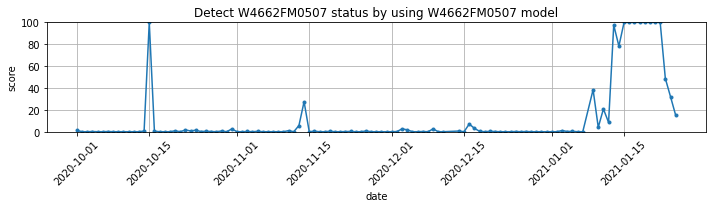

In [ ]:
da_rmse = mean_squared_error(target_score_da, target_score, squared=False)
cv_rmse = mean_squared_error(target_score_cv, target_score, squared=False)

plot_score (target_score_da, 
            target_date_da, 
            'Detect ' + tag2+' status by using '+tag1+' transformation model, RMSE=' + "{:.3f}".format(da_rmse))

plot_score (target_score_cv, 
            target_date_cv, 
            'Detect ' + tag2+' status by using '+tag1+' model, RMSE='+ "{:.3f}".format(cv_rmse))

plot_score (target_score, target_date, 'Detect ' + tag2+' status by using '+tag2+' model')

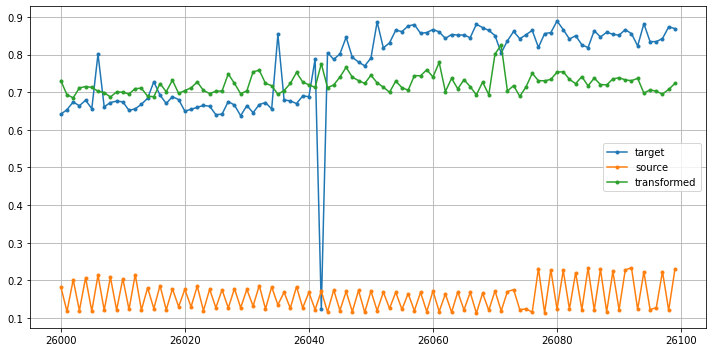

In [ ]:

feature_index = 206
duration = 26000
interval = 100
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(range(duration, duration+interval), X_target[feature_index].head(duration).tail(interval), label='target', marker='.')
ax.plot(range(duration, duration+interval), X_source[feature_index].head(duration).tail(interval), label='source', marker='.')
ax.plot(range(duration, duration+interval), y_recovered_pd[feature_index].head(duration).tail(interval), label='transformed', marker='.')

ax.legend()
ax.grid(True)
plt.tight_layout()

#plt.savefig('distribution.png', dpi=300)
plt.show()